# Develop status updates for field observabilities

In [1]:
from copy import copy
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
import seaborn as sns
import statsmodels.api as sm

from db import DBConnectorSQLite
from utilities import true_blocks

In [2]:
palette = {'not observable': 'r', 'init': 'orange', 'rising': 'g', 'plateauing': 'c', 'setting': 'b', 'unknown': '0.5'}

In [3]:
pd.set_option('display.max_rows', 100)

## Get data

Get fields that have observability entries with missing status information:

In [4]:
def get_fields_missing_status(db):
    """Get fields that have associated observing windows without
        observability status information.

        Parameters
        ----------
        db : db.DBConnectorSQLite
            Active database connection.

        Returns
        -------
        field_ids : numpy.ndarray
            Field IDs of fields with missing observing status.
        jd_min : numpy.ndarray
            JD of the first missing observing status corresponding to each
            field.
        jd_max : numpy.ndarray
            JD of the last missing observing status corresponding to each
            field.
    """

    fields = db.get_fields_missing_status()
    fields = pd.DataFrame(fields, columns=('field_id', 'jd'))
    fields = fields.groupby('field_id').agg(
            jd_min=('jd', 'min'), jd_max=('jd', 'max'))
    field_ids = fields.index.to_numpy()
    jd_min = fields['jd_min'].to_numpy()
    jd_max = fields['jd_max'].to_numpy()

    return field_ids, jd_min, jd_max

### Connect to database

The following database has observing windows, but no statuses stored:

In [457]:
db_file = 'test_status_init.sqlite3'
db = DBConnectorSQLite(db_file)

In [458]:
days_before = 7
days_after = 7

In [459]:
field_ids, jds_min, jds_max = get_fields_missing_status(db)
days_required = days_before + days_after + 1
jds_before = jds_min - days_before
jds_after = jds_max + days_after

In [460]:
print('Fields with missing status:', field_ids.shape[0])

Fields with missing status: 1393


### Select one of the fields for testing

I am selecting a specific case for developing the approaches below. Later I will iterate through more cases to show that the methods work well in general.

In [100]:
field_id = 400
i = np.nonzero(field_ids == field_id)[0][0]

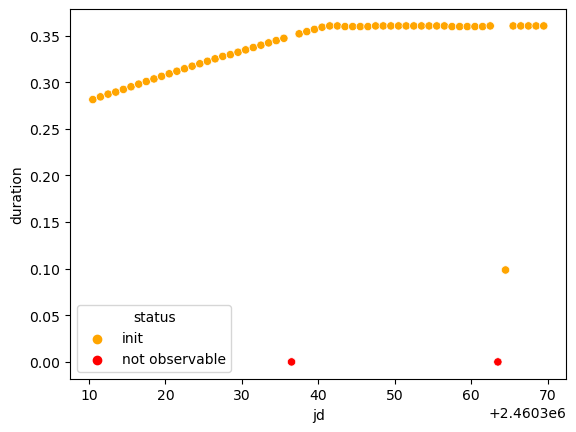

In [101]:
durations_init = db.get_obs_window_durations(
        field_ids[i], jds_before[i], jds_after[i])
durations_init = pd.DataFrame(
        durations_init, columns=('observability_id', 'jd', 'status', 'duration'))
durations_init = durations_init.groupby(['observability_id', 'jd', 'status']).sum()
durations_init.reset_index(inplace=True)
durations_init['setting_in'] = np.zeros(durations_init.shape[0]) * np.nan
durations_init['update'] = np.zeros(durations_init.shape[0], dtype=bool)

sns.scatterplot(data=durations_init, x='jd', y='duration', hue='status', palette=palette);
#print(durations_init)

## Determine status for new observabilities

### Too few data points to work with

If too few days are available to determine the status, we leave everything unchanged:

In [103]:
# create a shorter copy of the initial mock data above to demonstrate this part of the code:
durations = copy(durations_init)
durations = durations.iloc[:10]

In [104]:
if durations.shape[0] < days_required:
    print('Too few days')

Too few days


In [105]:
durations

,observability_id,jd,status,duration,setting_in,update
0,279,2460310.5,init,0.281420,NaN,False
1,1330,2460311.5,init,0.284344,NaN,False
2,2389,2460312.5,init,0.287248,NaN,False
3,3441,2460313.5,init,0.289439,NaN,False
4,4498,2460314.5,init,0.292304,NaN,False
5,5553,2460315.5,init,0.295151,NaN,False
6,6612,2460316.5,init,0.297978,NaN,False
7,7667,2460317.5,init,0.300785,NaN,False
8,8727,2460318.5,init,0.303572,NaN,False
9,9779,2460319.5,init,0.306339,NaN,False


### Data flagging

The next few sub-sections deal with the steps we run when enough data points are available. First we restore a copy of the full data set above:

In [110]:
# create a copy of the complete, initial mock data above to demonstrate this part of the code:
durations = copy(durations_init)

The first step in the analysis is data flagging. To determine whether an field is rising, plateauing, or setting we fit a range of durations around the day of interest with a linear function. However, some days the duration may be low or even zero due to as small seaparation from the Moon. Those affect the linear regression as outliers. We want to remove those. Zero durations can be easily removed, but small durations are more tricky.

#### Approach 1: residuals from a smoothed curve

My usual flagging approach I use for blazar light curves does not work here, as the example below shows:

In [15]:
def mask_outliers_hann(x, window_length, threshold):
    """Identify outliers.

    Parameters
    ----------
    x : array-like
        Time-sorted data sequence.
    window_length : int
        Defines the width of the Hann window function that is used to calculate
        a smoothed data curve.
    threshold : float
        Threshold for detecting outliers. Residuals that are larger than the
        mean residual value times this threshold factor are considered
        outliers.

    Raises
    ------
    ValueError
        Raised, if `window_length` is not an integer.

    Returns
    -------
    outlier : np.ndarray (dtype: bool)
        Items are True if a value in the input `x` is considered an outliers;
        False otherwise.
    x_smoothed : np.ndarray
        The smoothed data. Usually I do not return this, but for demonstration below I need to plot these.
    """

    # check input:
    x = np.asarray(x)

    if not isinstance(window_length, int):
        raise ValueError("`window_length` must be integer.")

    # smoothed data:
    s = np.r_[x[window_length-1:0:-1], x, x[-2:-window_length-1:-1]]
    w = np.hanning(window_length)
    n = int(np.floor(window_length/2))
    x_smoothed = np.convolve(w/w.sum(), s, mode='valid')[n:-n]

    # residuals:
    x_res = np.absolute(x - x_smoothed)
    mean_res = x_res.mean()

    # identify outliers:
    outlier = x_res > threshold * mean_res

    return outlier, x_smoothed

Irregardless which `window_length` we use, the wrong data points are flagged, because the smoothed data is strongly affected by the outliers:

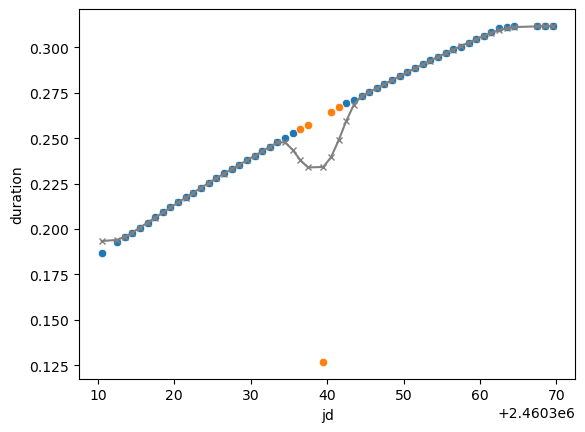

In [16]:
window_length = 11
sel_init = durations['status'] == 'init'
mask, s_smoothed = mask_outliers_hann(durations.loc[sel_init, 'duration'], window_length, 3)
sns.scatterplot(data=durations.loc[sel_init].loc[~mask], x='jd', y='duration')
sns.scatterplot(data=durations.loc[sel_init].loc[mask], x='jd', y='duration')
plt.plot(durations['jd'].loc[sel_init], s_smoothed, marker='x', color='0.5', ms=4);

#### Approach 2: Cook's distance

Here, I am using OLS from `statsmodels` which provides the [Cook's distance](https://en.wikipedia.org/wiki/Cook%27s_distance) as measure of influence on the fit.

First, I am selecting a subset of the data:

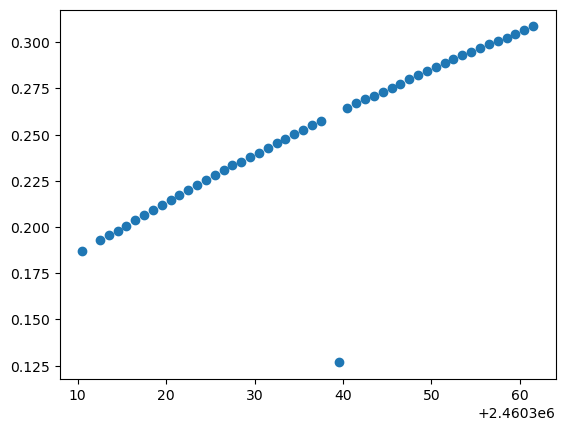

In [17]:
i0 = 0
i1 = 50

x = durations.loc[sel_init, 'jd'].iloc[i0:i1]
y = durations.loc[sel_init, 'duration'].iloc[i0:i1]
plt.plot(x, y, marker='o', linestyle='None');

Second, I am running the OLS fit and get the Cook's distance. The following plot shows the corresponding p-values:

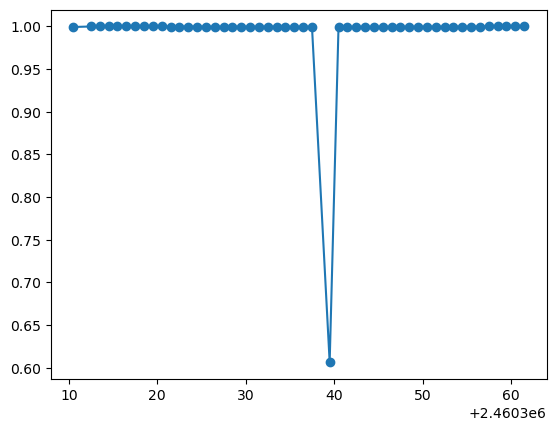

In [18]:
x_mod = sm.add_constant(x)
model = sm.OLS(y, x_mod).fit() 
influence = model.get_influence()
cooks, cooks_pval = influence.cooks_distance
plt.plot(x, cooks_pval, marker='o');

Third, I am marking those values as outliers that have a Cook's distance p-value < 0.6 (I need to test if this threshold works generally).
I remove ourliers and repeat the OLS:

In [24]:
mask = cooks_pval < 0.7
print('Any data points masked:', np.any(mask))
x_masked = durations.loc[sel_init, 'jd'].iloc[i0:i1].loc[~mask]
y_masked = durations.loc[sel_init, 'duration'].iloc[i0:i1].loc[~mask]
x_mod = sm.add_constant(x_masked)
model = sm.OLS(y_masked, x_mod).fit()
model.params

Any data points masked: True


const   -5839.724303
jd          0.002374
dtype: float64

This is the result:

Fit p-value (H0: zero slope): 5.704332537307967e-62


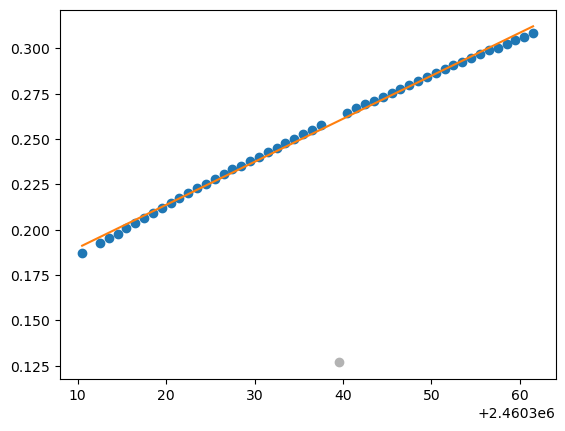

In [31]:
y_fit = model.params.const + x * model.params.jd
plt.plot(x[~mask], y[~mask], marker='o', ls='None')
plt.plot(x[mask], y[mask], marker='o', color='0.7', ls='None')
plt.plot(x, y_fit, marker='None', ls='-')
print('Fit p-value (H0: zero slope):', model.pvalues[1])

We write up the above approach as a function:

In [33]:
def mask_outlier_cook(jd, duration, outlier_threshold=0.7):
    """Linear ordinary least square regression with exclusion of outliers.
    
    Parameters
    ----------
    jd : array-like
        JD.
    duration : array-like
        Durations of the observing windows for each JD.
    outlier_threshold : float, optional
        Threshold for outlier detection. Data points with a Cook's distance p-value
        lower than this threshold are considered outliers and excluded from the 
        regression. The default is 0.6.
        
    Returns
    -------
    sel_outl : numpy.ndarray (dtype: bool)
        True, for detected outliers. False, otherwise.
    """
    
    x = np.asarray(jd)
    y = np.asarray(duration)
    
    # linear regression:
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit() 
    
    # check for outliers:
    influence = model.get_influence()
    __, cooks_pval = influence.cooks_distance
    sel_outl = cooks_pval < outlier_threshold
    
    return sel_outl

Test different values:

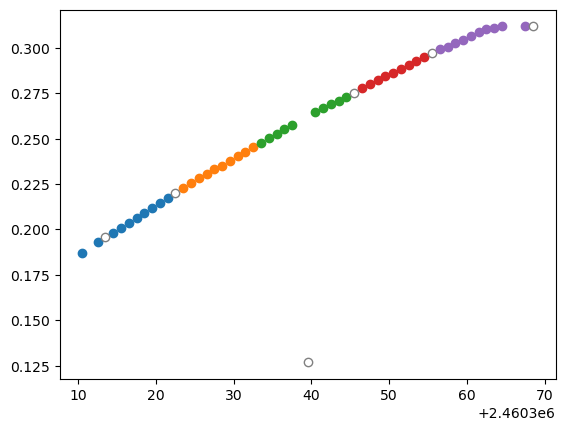

In [38]:
n_dp = 11
outlier_threshold = 0.7

for i0 in np.arange(0, durations.shape[0]-n_dp, n_dp):
    i1 = i0 + n_dp
    jd = durations.loc[sel_init, 'jd'].iloc[i0:i1]
    duration = durations.loc[sel_init, 'duration'].iloc[i0:i1]
    sel_outl = mask_outlier_cook(jd, duration, outlier_threshold=outlier_threshold)
    
    plt.plot(jd[~sel_outl], duration[~sel_outl], ls='None', marker='o')
    plt.plot(jd[sel_outl], duration[sel_outl], ls='None', marker='o', mfc='w', color='0.5')

Playing with the number of data points that we select for fitting, `n_dp`, and the outlier detection threshold, `outlier_threshold`, shows that they strongly affect which data points are selected as outliers:

**Results:**
* A higher threshold, e.g. `0.8`, largely increases the number of "outliers". This is not reasonable.
* A lower threshold, e.g. `0.5`, will miss some outliers.
* The value of `0.7` seems to be a good compromise for this test case. Even though it misclassifies some data points as outliers.
* The selection of the threshold also depends on the number of data points. With more data points, e.g. `12`, the impact of single data points becomes smaller, thus a "clear" outlier may not be detected as such.
* Vice versa with a smaller number of data points, e.g. `7`, the impact of individual data points increases and starting or ending points of a data subset, which typically have stronger impact than other data points (except outliers), may be misclassified as outliers.

**Discussion:**
None of the above really matters much. We want to make sure to remove the strongest outliers, because the can result in poor estimates of the slope and, thus, misclassification of the status. False outlier detection occasionally removes data points that do not change the slope drastically. Therefore, we do not care. Therefore, it is of higher importance to check further below that the status classification works well, rather than getting the outlier classification absolutely right.

### Status classification

I am selecting a specific case for developing the approaches below. Later I will iterate through more cases to show that the methods work well in general.

#### Approach 1: linear regression p-value

**Criterion:** We use the linear regression p-value to distinguish plateauing from rising or setting.

In [244]:
def get_status(jd, jds, durations, status_threshold=0.001, mask_outl=None):
    """Status based on linear ordinary least square regression with exclusion of outliers.
    
    Parameters
    ----------
    jd : float
        JD of the date of interest.
    jds : array-like
        JDs of the observing windows.
    durations : array-like
        Durations of the observing windows for each JD.
    status_threshold : float, optional
        Threshold for distinguishing plateauing from rising or setting. If the OLS p-value is 
        larger than this threshold, the status is considered "plateauing"; otherwise "rising" 
        or "setting" depending on the slope. The default is 0.001.
    mask_outl : numpy.ndarray (dtype: bool) or None, optional
        If given, Trues mark outliers that are removed from the OLS. The default is None.
        
    Returns
    -------
    status : str
        Either "rising", "plateauing", or "setting".
    setting_in : float
        If the status is "setting" this is the duration in days, when the field is setting.
        Otherwise a numpy.nan is returned.
    """
    
    x = np.asarray(jds)
    y = np.asarray(durations)
    
    # remove outliers:
    if mask_outl is not None:
        x = x[~mask_outl]
        y = y[~mask_outl]
    
    # linear regression:
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    pval = model.pvalues[1]
    slope = model.params[1]
    intercept = model.params[0]
    
    # get status:
    if pval >= status_threshold:
        status = 'plateauing'
        setting_in = np.nan
        
    elif slope > 0:
        status = 'rising'
        setting_in = np.nan
        
    else:
        status = 'setting'
        setting_in = -intercept / slope - jd
        
    return status, setting_in

Test:

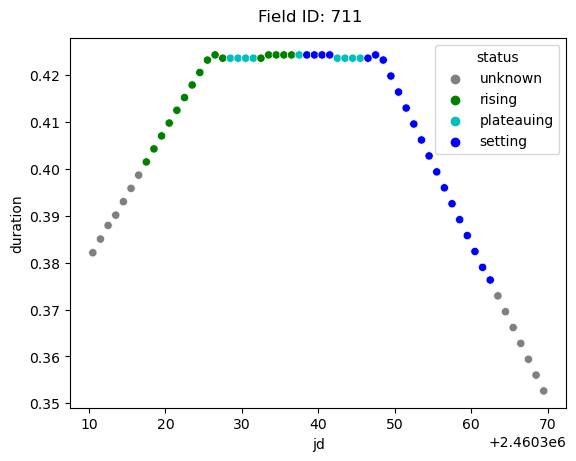

In [245]:
# test configuration:
days_before, days_after = 7, 7
outlier_threshold = 0.7
status_threshold = 0.001
field_id = 711
verbose = 0

#------------------------------------------
# get random field, if no ID is specified:
if field_id is None:
    i = np.random.randint(len(field_ids))
    field_id = field_ids[i]
else:
    i = np.nonzero(field_ids == field_id)[0][0]

# get initial data for that field:
durations = db.get_obs_window_durations(
        field_ids[i], jds_before[i], jds_after[i])
durations = pd.DataFrame(
        durations, columns=('observability_id', 'jd', 'status', 'duration'))
durations = durations.groupby(['observability_id', 'jd', 'status']).sum()
durations.reset_index(inplace=True)
durations['setting_in'] = np.zeros(durations.shape[0]) * np.nan
durations['update'] = np.zeros(durations.shape[0], dtype=bool)

sel_init = durations['status'] == 'init'

for i in np.nonzero(sel_init.to_numpy())[0]:
    jd = durations.iloc[i]['jd']
    jd_before = jd - days_before
    jd_after = jd + days_after
    sel_time = np.logical_and.reduce([
            durations['jd'] >= jd_before,
            durations['jd'] <= jd_after,
            durations['status'] != 'not observable'])

    if (durations.loc[sel_time, 'jd'].iloc[0] != jd_before or
            durations.loc[sel_time, 'jd'].iloc[-1] != jd_after):
        status = 'unknown'
        durations.at[i, 'status'] = status

    else:
        mask_outl = mask_outlier_cook(
                durations.loc[sel_time, 'jd'], durations.loc[sel_time, 'duration'], outlier_threshold=outlier_threshold)
        status, setting_in = get_status(
                jd, durations.loc[sel_time, 'jd'], durations.loc[sel_time, 'duration'], status_threshold=status_threshold, 
                mask_outl=mask_outl)
        durations.at[i, 'status'] = status
        durations.at[i, 'update'] = True
        
        if status == 'setting':
            durations.at[i, 'setting_in'] = setting_in
            
        if verbose and np.any(mask_outl):
            print(f'Point {i}, outliers', np.nonzero(mask_outl)[0])

# plot result:
sns.scatterplot(data=durations, x='jd', y='duration', hue='status', palette=palette)
plt.suptitle(f'Field ID: {field_id}', y=0.94);

**Results:**

* With seven days before and after, the results look pretty good.
* Some points remain unclassified, when the first or last data point is "not observable". These classification gaps are not critical. They will be fixed later.
* Bad cases occure in plateauing phases, where the duration jumps due to insufficient accuracy, gives very poor results (e.g. ID 134, 138, 711).

#### Approach 2: First half vs second half

With the approach above I had some issues, when I was using 5 days before and after. This is why I tested this second appoach.

**Criterion:** If the second half of the durations is not significantly different from the first half, we consider the status plateauing. Otherwise, if the second half is larger than the first, the status is rising; if it is smaller, the status is setting.

Quick demonstration:

0.375 0.3903123748998999 False


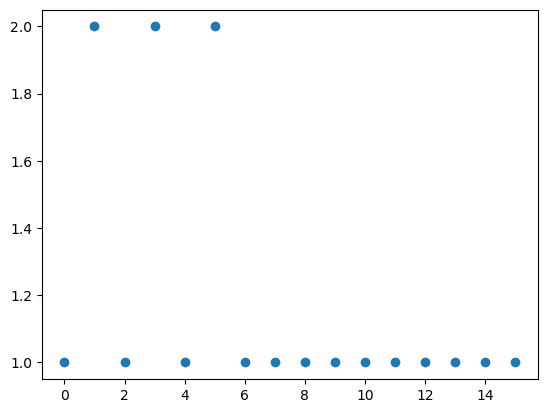

In [222]:
x = np.array([1,2,1,2,1,2,1,1,1,1,1,1,1,1,1,1])

plt.plot(x, linestyle='None', marker='o')

n = len(x)
print(x[:n//2].mean() - x[n//2:].mean(), x.std(), np.abs(x[:n//2].mean() - x[n//2:].mean()) > x.std())

-0.46000000000000013 0.26851443164195105 True


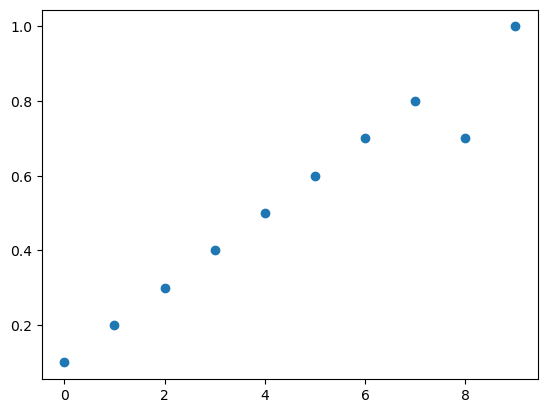

In [223]:
x = np.array([1,2,3,4,5,6,7,8,7,10]) * 0.1

plt.plot(x, linestyle='None', marker='o')

n = len(x)
print(x[:n//2].mean() - x[n//2:].mean(), x.std(), np.abs(x[:n//2].mean() - x[n//2:].mean()) > x.std())

Write up as function:

In [242]:
def get_status(jd, jds, durations, status_threshold=1, mask_outl=None):
    """Status based relative changes between first and second half of the data.
    
    Parameters
    ----------
    jd : float
        JD of the date of interest.
    jds : array-like
        JDs of the observing windows.
    durations : array-like
        Durations of the observing windows for each JD.
    status_threshold : float, optional
        Threshold for distinguishing plateauing from rising or setting. If the first half of the data
        is larger than the second half by more than the standard deviation of the data multiplied with
        this threshold, then the status is "rising" or "setting", depending on the values. Otherwise,
        the status is "plateauing". The default is 1.
    mask_outl : numpy.ndarray (dtype: bool) or None, optional
        If given, Trues mark outliers that are removed from the analysis. The default is None.
        
    Returns
    -------
    status : str
        Either "rising", "plateauing", or "setting".
    setting_in : float
        If the status is "setting" this is the duration in days, when the field is setting.
        Otherwise a numpy.nan is returned.
    """
    
    x = np.asarray(jds)
    y = np.asarray(durations)
    
    # remove outliers:
    if mask_outl is not None:
        x = x[~mask_outl]
        y = y[~mask_outl]
    
    # calculate difference between first and second half of data:
    n = x.shape[0]
    y_diff = y[n//2:].mean() - y[:n//2].mean()
    #y_diff = np.median(y[n//2:]) - np.median(y[:n//2])
    y_std = y.std()
    diff_lt_std = np.abs(y_diff) > y_std * status_threshold
    
    # get status:
    if diff_lt_std and y_diff > 0:
        status = 'rising'
        setting_in = np.nan
        
    elif diff_lt_std:
        status = 'setting'
        
        # linear regression for setting duration:
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        slope = model.params[1]
        intercept = model.params[0]
        setting_in = -intercept / slope - jd
    
    else:
        status = 'plateauing'
        setting_in = np.nan
        
    return status, setting_in

Test:

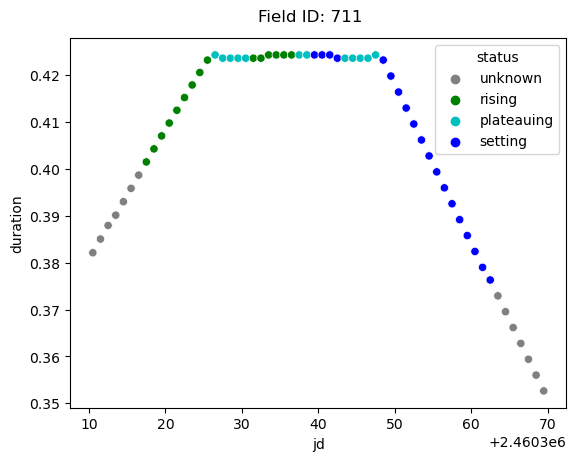

In [243]:
# test configuration:
days_before, days_after = 7, 7
outlier_threshold = 0.7
status_threshold = 1.4
field_id = None

#------------------------------------------
# get random field, if no ID is specified:
if field_id is None:
    i = np.random.randint(len(field_ids))
    field_id = field_ids[i]
else:
    i = np.nonzero(field_ids == field_id)[0][0]

# get initial data for that field:
durations = db.get_obs_window_durations(
        field_ids[i], jds_before[i], jds_after[i])
durations = pd.DataFrame(
        durations, columns=('observability_id', 'jd', 'status', 'duration'))
durations = durations.groupby(['observability_id', 'jd', 'status']).sum()
durations.reset_index(inplace=True)
durations['setting_in'] = np.zeros(durations.shape[0]) * np.nan
durations['update'] = np.zeros(durations.shape[0], dtype=bool)

sel_init = durations['status'] == 'init'

for i in np.nonzero(sel_init.to_numpy())[0]:
    jd = durations.iloc[i]['jd']
    jd_before = jd - days_before
    jd_after = jd + days_after
    sel_time = np.logical_and.reduce([
            durations['jd'] >= jd_before,
            durations['jd'] <= jd_after,
            durations['status'] != 'not observable'])

    if (durations.loc[sel_time, 'jd'].iloc[0] != jd_before or
            durations.loc[sel_time, 'jd'].iloc[-1] != jd_after):
        status = 'unknown'
        durations.at[i, 'status'] = status

    else:
        mask_outl = mask_outlier_cook(
                durations.loc[sel_time, 'jd'], durations.loc[sel_time, 'duration'], outlier_threshold=outlier_threshold)
        status, setting_in = get_status(
                jd, durations.loc[sel_time, 'jd'], durations.loc[sel_time, 'duration'], status_threshold=status_threshold, 
                mask_outl=mask_outl)
        durations.at[i, 'status'] = status
        durations.at[i, 'update'] = True
        
        if status == 'setting':
            durations.at[i, 'setting_in'] = setting_in

# plot result:
sns.scatterplot(data=durations, x='jd', y='duration', hue='status', palette=palette)
plt.suptitle(f'Field ID: {field_id}', y=0.94);

**Results:**

* Same isues as with the first approach in the plateauing phases (e.g. ID 134, 138, 711).
* Some points remain unclassified, when the first or last data point is "not observable". These classification gaps are not critical. They will be fixed later.

#### Approach 3: variability exceeding sampling accuracy

**Criterion:** We classify as plateauing, when the variability does not exceed the sampling accuracy. Rising/setting otherwise, depending on the sign.

In [461]:
def get_status(jd, jds, durations, time_interval, status_threshold=6, mask_outl=None):
    """Status based on linear ordinary least square regression with exclusion of outliers.
    
    Parameters
    ----------
    jd : float
        JD of the date of interest.
    jds : array-like
        JDs of the observing windows.
    durations : array-like
        Durations of the observing windows for each JD.
    time_interval : float
        Time interval of the duration sampling in seconds. The status is considered "plateauing" if the standard deviation
        of the durations is smaller than this time interval times the status_threshold.
    status_threshold : float, optional
        Scaling factor. See description of time_interval. The default is 6.
    mask_outl : numpy.ndarray (dtype: bool) or None, optional
        If given, Trues mark outliers that are removed from the OLS. The default is None.
        
    Returns
    -------
    status : str
        Either "rising", "plateauing", or "setting".
    setting_in : float
        If the status is "setting" this is the duration in days, when the field is setting.
        Otherwise a numpy.nan is returned.
    """
    
    x = np.asarray(jds)
    y = np.asarray(durations)
    
    # remove outliers:
    if mask_outl is not None:
        x = x[~mask_outl]
        y = y[~mask_outl]
    
    # get status:
    if y.std() <= time_interval / 24 / 3600 * status_threshold:
        status = 'plateauing'
        setting_in = np.nan
        
    elif np.median(np.diff(y)) > 0:
        status = 'rising'
        setting_in = np.nan
        
    else:
        status = 'setting'
        
        # linear regression for setting duration:
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        slope = model.params[1]
        intercept = model.params[0]
        setting_in = -intercept / slope - jd
    
    return status, setting_in

Test:

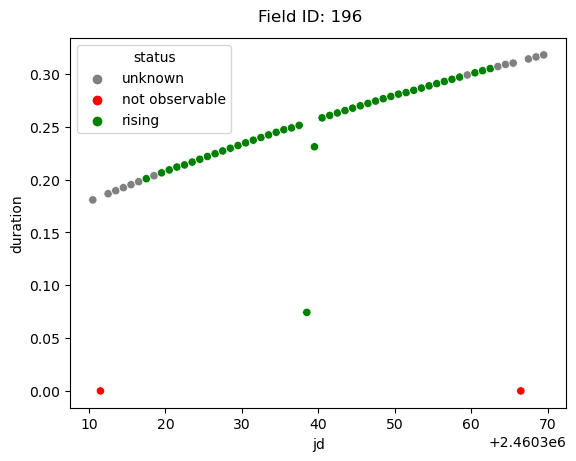

In [477]:
# test configuration:
days_before, days_after = 7, 7
outlier_threshold = 0.7
time_interval = 60
status_threshold = 6
field_id = 196
verbose = 0

#------------------------------------------
# get random field, if no ID is specified:
if field_id is None:
    i = np.random.randint(len(field_ids))
    field_id = field_ids[i]
else:
    i = np.nonzero(field_ids == field_id)[0][0]

# get initial data for that field:
durations = db.get_obs_window_durations(
        field_ids[i], jds_before[i], jds_after[i])
durations = pd.DataFrame(
        durations, columns=('observability_id', 'jd', 'status', 'duration'))
durations = durations.groupby(['observability_id', 'jd', 'status']).sum()
durations.reset_index(inplace=True)
durations['setting_in'] = np.zeros(durations.shape[0]) * np.nan
durations['update'] = np.zeros(durations.shape[0], dtype=bool)

sel_init = durations['status'] == 'init'

for i in np.nonzero(sel_init.to_numpy())[0]:
    jd = durations.iloc[i]['jd']
    jd_before = jd - days_before
    jd_after = jd + days_after
    sel_time = np.logical_and.reduce([
            durations['jd'] >= jd_before,
            durations['jd'] <= jd_after,
            durations['status'] != 'not observable'])

    if (durations.loc[sel_time, 'jd'].iloc[0] != jd_before or
            durations.loc[sel_time, 'jd'].iloc[-1] != jd_after):
        status = 'unknown'
        durations.at[i, 'status'] = status

    else:
        mask_outl = mask_outlier_cook(
                durations.loc[sel_time, 'jd'], durations.loc[sel_time, 'duration'], outlier_threshold=outlier_threshold)
        status, setting_in = get_status(
                jd, durations.loc[sel_time, 'jd'], durations.loc[sel_time, 'duration'], time_interval, status_threshold=status_threshold,
                mask_outl=mask_outl)
        durations.at[i, 'status'] = status
        durations.at[i, 'update'] = True
        
        if status == 'setting':
            durations.at[i, 'setting_in'] = setting_in
            
        if verbose and np.any(mask_outl):
            print(f'Point {i}, outliers', np.nonzero(mask_outl)[0])
        
# plot result:
sns.scatterplot(data=durations, x='jd', y='duration', hue='status', palette=palette)
plt.suptitle(f'Field ID: {field_id}', y=0.94);

**Results:**

- This appraoch seems to work reliably.

#### Comparison of the three approaches

**Conclusion:** I will use the third approach in the final code.

### Status for first data points initially classified as "unknown" 

There are one or two blocks of days with unknown status:
* A block at the end will be the usual case, because the last days will never be considered in the status classification. We will leave them untouched until observing blocks for the following days have been calculated.
* A block at the beginning occurs when we run the classification for the first time. In this case we can simply change those unknown cases to the status of the next known status. This may not be correct in all cases. E.g. the first data points could be rising, the next plateauing, and we will set everything to plateauing. The same with pleateauing and setting. However, this is not really that relevant. Best case scenario: If we want to start the survey on 2024-04-01 we start the observing window calculations with 2024-03-25 to include seven days before the first date of interest. One thing to take care of: If the next data point has status "not observable", because e.g. the Moon is too close, we should not set all preceeding statuses to "not observable". Instead we will check the next entries and use the next status that is not "not observable". If all next ones are "not observable" this indicates that the previous statuses should have been "setting".
* The final points before all are "note observable" are also not classified. This case is also covered by the above, as all of these will be classified as "setting".

To do this we need two steps:
1. Identify the blocks with unknown status. 
2. Iterate through those blocks. We need to do this in reverse order. Otherwise, The next status that is not "not observable" may again be "unknown", if a block is split in two parts due to a non-observable point in-between. This issue will not arise when we iterate through blocks in reverse.
3. Kick out if the block or one of the blocks is the final data.
4. Do not update if the next status again is "unknown". This case may occur when the final block is split into two due to non-observable points in-between.
2. Update the status for the remaining block.

In [476]:
def update_unknown_status(durations):
    """Update the status where unknown, if possible.
    
    Parameters
    ----------
    durations : pandas.DataFrame
        Observing window durations and status information.
    
    Notes
    -------
    Changes are done inplace, therefore the dataframe does not have to be returned.
    """
    
    # identify blocks with unknown status:
    sel_unk = durations['status'] == 'unknown'
    
    # iterate through these blocks in reverse:
    for i0, i1 in true_blocks(sel_unk)[::-1]:
        
        # skip blocks at the end:
        if i1 == durations.shape[0] - 1:
            continue
        
        # otherwise, update status based on next one that is not "not observable":
        for j in range(1, 5):
            # try to get next status, break if no more are available:
            try:
                status = durations['status'][i1+j]
            except KeyError:
                break
            
            # if status is "not observable", go to next status:
            if status == 'not observable':
                continue
            
            # update status:
            if status != 'unknown':
                durations.loc[i0:i1, 'status'] = status
                durations.loc[i0:i1, 'update'] = True

            # extrapolate setting duration, if needed:
            if status == 'setting':
                setting_in = durations['setting_in'][i1+j] + j - 1
                setting_in += np.arange(i1 - i0 + 1, 0, -1)
                durations.loc[i0:i1, 'setting_in'] = setting_in
            
            break
        
        # all next statuses are "not observable"
        else:
            durations.loc[i0:i1, 'status'] = 'setting'
            durations.loc[i0:i1, 'update'] = True
            durations.loc[i0:i1, 'setting_in'] = np.arange(i1 - i0, -1, -1)

Test case: "unknown" status followed by "not observable" followed by setting (could also be rising or plateauing):

In [91]:
durations = pd.DataFrame({
        'status': ['unknown']*7 + ['not observable']*2 + ['setting']*1,
        'setting_in': [0]*9 + [12],
        'update': [False]*10
        })
durations

,status,setting_in,update
0,unknown,0,False
1,unknown,0,False
2,unknown,0,False
3,unknown,0,False
4,unknown,0,False
5,unknown,0,False
6,unknown,0,False
7,not observable,0,False
8,not observable,0,False
9,setting,12,False


In [92]:
update_unknown_status(durations)

In [93]:
durations

,status,setting_in,update
0,setting,21,True
1,setting,20,True
2,setting,19,True
3,setting,18,True
4,setting,17,True
5,setting,16,True
6,setting,15,True
7,not observable,0,False
8,not observable,0,False
9,setting,12,False


Test case: "unknown" status followed only by "not observable":

In [94]:
durations = pd.DataFrame({
        'status': ['unknown']*7 + ['not observable']*5,
        'setting_in': [0]*12,
        'update': [False]*12
        })
durations

,status,setting_in,update
0,unknown,0,False
1,unknown,0,False
2,unknown,0,False
3,unknown,0,False
4,unknown,0,False
5,unknown,0,False
6,unknown,0,False
7,not observable,0,False
8,not observable,0,False
9,not observable,0,False


In [95]:
update_unknown_status(durations)

In [96]:
durations

,status,setting_in,update
0,setting,6,True
1,setting,5,True
2,setting,4,True
3,setting,3,True
4,setting,2,True
5,setting,1,True
6,setting,0,True
7,not observable,0,False
8,not observable,0,False
9,not observable,0,False


Test case: "Plateauing" followed by "unknown" followed by "not observable":

In [412]:
durations = pd.DataFrame({
        'status': ['plateauing']*2 + ['unknown']*5 + ['not observable']*5,
        'setting_in': [0]*12,
        'update': [False]*12
        })
durations

,status,setting_in,update
0,plateauing,0,False
1,plateauing,0,False
2,unknown,0,False
3,unknown,0,False
4,unknown,0,False
5,unknown,0,False
6,unknown,0,False
7,not observable,0,False
8,not observable,0,False
9,not observable,0,False


In [413]:
update_unknown_status(durations)

In [414]:
durations

,status,setting_in,update
0,plateauing,0,False
1,plateauing,0,False
2,setting,4,True
3,setting,3,True
4,setting,2,True
5,setting,1,True
6,setting,0,True
7,not observable,0,False
8,not observable,0,False
9,not observable,0,False


Test case: Just a single "unknown" in between:

In [453]:
durations = pd.DataFrame({
        'status': ['rising']*5 + ['unknown'] + ['rising']*6,
        'setting_in': [0]*12,
        'update': [False]*12
        })
durations

,status,setting_in,update
0,rising,0,False
1,rising,0,False
2,rising,0,False
3,rising,0,False
4,rising,0,False
5,unknown,0,False
6,rising,0,False
7,rising,0,False
8,rising,0,False
9,rising,0,False


In [454]:
update_unknown_status(durations)

In [455]:
durations

,status,setting_in,update
0,rising,0,False
1,rising,0,False
2,rising,0,False
3,rising,0,False
4,rising,0,False
5,rising,0,True
6,rising,0,False
7,rising,0,False
8,rising,0,False
9,rising,0,False


## Check results in the database

The following database coontains the status classifications. I am using it to check the results:

In [480]:
db_file = 'test_status.sqlite3'
db = DBConnectorSQLite(db_file)

In [481]:
fields = np.array(db.get_fields())
field_ids = fields[:, 0].astype(int)
jds_min = fields[:, 7].astype(float)
jds_max = fields[:, 8].astype(float)

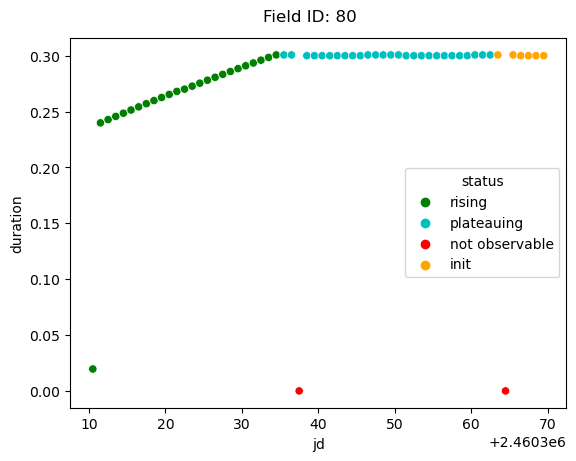

In [525]:
field_id = None # 1392

# get random field, if no ID is specified:
if field_id is None:
    i = np.random.randint(len(field_ids))
    field_id = field_ids[i]
else:
    i = np.nonzero(field_ids == field_id)[0][0]
    
durations = db.get_obs_window_durations(
        field_ids[i], jds_min[i], jds_max[i])
durations = pd.DataFrame(
        durations, columns=('observability_id', 'jd', 'status', 'duration'))
durations = durations.groupby(['observability_id', 'jd', 'status']).sum()
durations.reset_index(inplace=True)

sns.scatterplot(data=durations, x='jd', y='duration', hue='status', palette=palette)
plt.suptitle(f'Field ID: {field_ids[i]}', y=0.94);

**Conclusion:** The results look really good.

## Performance tests

In this section I am testing what accuracy we need in the refined time grid to get the status classification as good as needed. We cannot go for arbitrary accuracy, because that increases the runtime of the observability field calculation.

For these tests I ran the observability window calculation with three different initial and refined time intervals.
In the following I will check how well we can determine the observability status.

### Run tests

In [5]:
test_time_init = [300, 600]
test_time_refine = [10, 30, 60]

Get fields (it does not matter to which database we connect to get the fields):

In [7]:
days_before = 7
days_after = 7

In [8]:
db = DBConnectorSQLite(f'test_timegrid_{test_time_init[0]}-{test_time_refine[0]}.sqlite3')
field_ids, jds_min, jds_max = get_fields_missing_status(db)
days_required = days_before + days_after + 1
jds_before = jds_min - days_before
jds_after = jds_max + days_after
print(f'Fields missing observability status: {field_ids.shape[0]}')

Fields missing observability status: 1285


In [9]:
db = DBConnectorSQLite(f'test_timegrid_{test_time_init[0]}-{test_time_refine[0]}.sqlite3')
results = np.array(db.get_fields())
field_ids = results[:,0].astype(int)
jd0 = np.unique(results[:,7].astype(float))[0]
jd1 = np.unique(results[:,8].astype(float))[0]
del results

Get all observability status classifications from all test databases (this takes several minutes):

In [10]:
durations = {}

# iterate though different time grids:
for time_init, time_refine in product(test_time_init, test_time_refine):
    tag = f'{time_init}-{time_refine}'
    print(f'Analyse time grid {tag}..')
    db = DBConnectorSQLite(f'test_timegrid_{time_init}-{time_refine}.sqlite3')
    
    # iterate through fields:
    for i, field_id in enumerate(field_ids):
        print(f'\r  Progress: {i} of {field_ids.shape[0]} ({i/field_ids.shape[0]*100:.1f}%)..', end='')
        
        if field_id not in durations.keys():
            durations[field_id] = {}
        
        # get observability window durations:
        i = np.nonzero(field_ids == field_id)[0][0]
        dur = db.get_obs_window_durations(field_ids[i], jd0, jd1)
        dur = pd.DataFrame(dur, columns=('observability_id', 'jd', 'status', 'duration'))
        dur['duration'] = np.where(dur['status'] == 'not observable', 0, dur['duration'])
        dur = dur.drop('observability_id', axis=1)
        durations[field_id][tag] = dur
    
    print('\r  Progress: done.                 ')

Analyse time grid 300-10..
  Progress: done.                 
Analyse time grid 300-30..
  Progress: done.                 
Analyse time grid 300-60..
  Progress: done.                 
Analyse time grid 600-10..
  Progress: done.                 
Analyse time grid 600-30..
  Progress: done.                 
Analyse time grid 600-60..
  Progress: done.                 


Check for consistency in the status classification between best sampled time grid and other test grids:

In [11]:
tags = [f'{time_init}-{time_refine}' for time_init, time_refine in product(test_time_init, test_time_refine)]
tag0 = tags[0]
tags = tags[1:]

In [12]:
consistency = {'field_id': []} | {tag: [] for tag in tags}

for field_id in field_ids:
    consistency['field_id'].append(field_id)

    for tag in tags:
        consistent = np.all(durations[field_id][tag]['status'] == durations[field_id][tag0]['status'])
        consistency[tag].append(consistent)
    
consistency = pd.DataFrame(consistency)
consistency['all'] = np.all(consistency.iloc[:,1:], axis=1)
consistency

,field_id,300-30,300-60,600-10,600-30,600-60,all
0,1,True,True,True,True,True,True
1,2,True,True,True,True,True,True
2,3,True,True,True,True,True,True
3,4,True,True,True,True,True,True
4,5,True,True,True,True,True,True
...,...,...,...,...,...,...,...
1568,1569,True,True,True,True,True,True
1569,1570,True,True,True,True,True,True
1570,1571,True,True,True,True,True,True
1571,1572,True,True,True,True,True,True


### Results

In [13]:
consistency_stats = {'test': [], 'consistency count': [], 'consistency ratio (%)': [], 'failed count': [], 'failed ratio (%)': []}

for tag in tags + ['all']:
    n = np.sum(consistency[tag])
    r = np.round(n / field_ids.shape[0] * 100, 1)
    consistency_stats['test'].append(tag)
    consistency_stats['consistency count'].append(n)
    consistency_stats['consistency ratio (%)'].append(r)
    consistency_stats['failed count'].append(field_ids.shape[0] - n)
    consistency_stats['failed ratio (%)'].append(100-r)
    
consistency_stats = pd.DataFrame(consistency_stats)
consistency_stats

,test,consistency count,consistency ratio (%),failed count,failed ratio (%)
0,300-30,1472,93.6,101,6.4
1,300-60,1434,91.2,139,8.8
2,600-10,1511,96.1,62,3.9
3,600-30,1456,92.6,117,7.4
4,600-60,1419,90.2,154,9.8
5,all,1417,90.1,156,9.9


### Show examples

In [14]:
field_ids_failed = consistency.loc[~consistency['all'], 'field_id'].to_numpy()

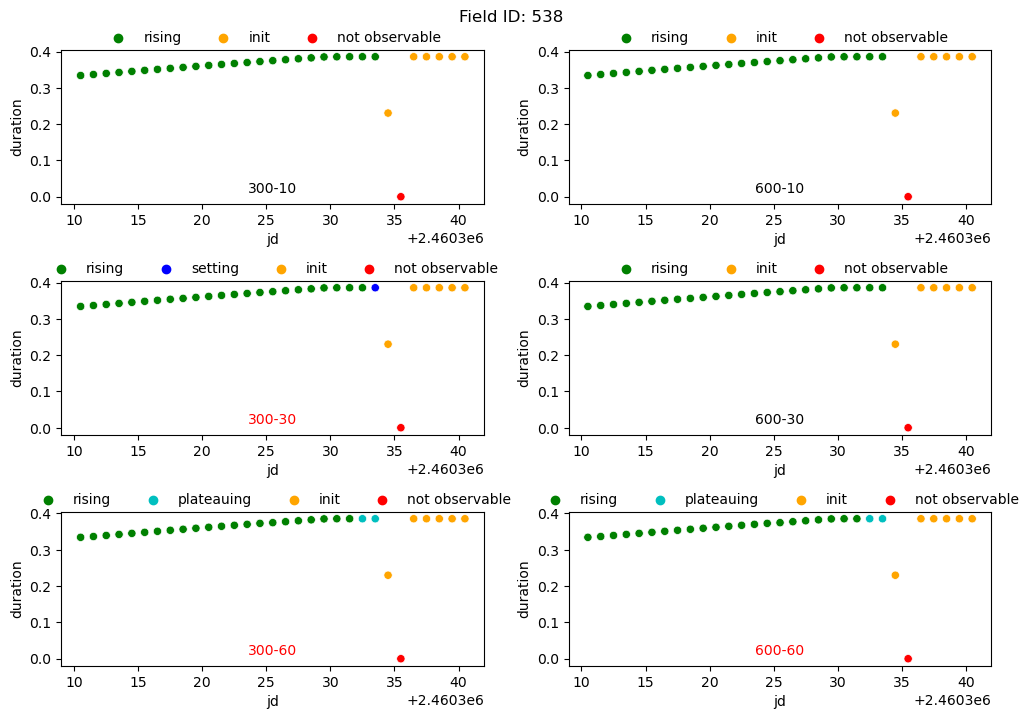

In [34]:
i = np.random.randint(field_ids_failed.shape[0])
field_id = field_ids_failed[i]

# create figure:
__, ax0 = plt.subplots(3, 2, figsize=(12, 8), num=1, clear=True)
plt.subplots_adjust(hspace=0.5)
plt.suptitle(f'Field ID: {field_id}', y=0.93);


for i, tag in enumerate(durations[field_id].keys()):
    sns.scatterplot(data=durations[field_id][tag], x='jd', y='duration', hue='status', palette=palette, ax=ax0[i%3,i//3])
    sns.move_legend(ax0[i%3,i//3], "lower center", bbox_to_anchor=(.5, 0.95), ncol=5, title=None, frameon=False)
    if i > 0:
        consistent = consistency.loc[consistency['field_id']==field_id, tag].values[0]
        color = 'k' if consistent else 'r'
    else:
        color = 'k'
    ax0[i%3,i//3].text(
            0.5, 0.1, tag, color=color, horizontalalignment='center', verticalalignment='center', transform=ax0[i%3,i//3].transAxes)

### Runtime

In [55]:
runtime = pd.read_csv(
        'timegrid_tests.dat',
        names=['computer', 'time_start', 'time_stop', 'n_days', 'interval_init', 'interval_refine', 'processes', 
               'batch_write', 'test_id', 'runtime (days)']
        )
runtime.sort_values(by=['interval_init', 'interval_refine'], ignore_index=True, inplace=True)
runtime['runtime (min)'] = runtime['runtime (days)'] * 24 * 60
del runtime['runtime (days)']
runtime

,computer,time_start,time_stop,n_days,interval_init,interval_refine,processes,batch_write,test_id,runtime (min)
0,kallisto,2024-01-01 00:00:00.000,2024-02-01 00:00:00.000,31,300,10,10,10000,0,121.337479
1,kallisto,2024-01-01 00:00:00.000,2024-02-01 00:00:00.000,31,300,30,10,10000,0,98.306519
2,kallisto,2024-01-01 00:00:00.000,2024-02-01 00:00:00.000,31,300,60,10,10000,0,86.515914
3,kallisto,2024-01-01 00:00:00.000,2024-02-01 00:00:00.000,31,600,10,10,10000,0,126.924310
4,kallisto,2024-01-01 00:00:00.000,2024-02-01 00:00:00.000,31,600,30,10,10000,0,93.261819
5,kallisto,2024-01-01 00:00:00.000,2024-02-01 00:00:00.000,31,600,60,10,10000,0,79.448332


### Conclusions

- For the cases where 600-60 differs from 300-10, 600-60 often gives the better result. Often
    - Plateauing and rising are better distinguished, likely because I tweaked the parameters to work for 600-60. I am still surprised, because the differences in the durations should not be this large and the trends should be basically the same.
    - Sometimes days are differently defined as observable or not observable, when the window is very short. This makes sense given the different sampling.
- In some cases 600-60 does classify the rising part as plateauing. In the end this is not too critical.
- I will use 600-60.